# In this notebook, We demonstrate End 2 End flow of Anomaly detection in a  Dataset that has been scraped from Flowkey website.



1.   Place the original MIDI files that have been obtained by converting Sheet Music image files in **'/GtruthMIDIFiles_SharpEye'** folder.
2.   Place the corresponding 'wav' file recordings in **'/WavFiles'** folder.
3.   Loop over the **'/WavFiles'** folder processing each file one by one:
    1. Transcribe the file into MIDI and place it into **'/TranscribedFiles'** folder.
    2. Fetch the corresponding Ground Truth MIDI from **'/GtruthMIDIFiles_SharpEye'** folder.
    3. Run the comparison functions to get the Confusion matrix and Accuracy score.
    4. Push the accuracy score in a list.

4.  Once, processing of all the files are completed, take the **mean accuracy** to obtain the final accuracy.




# Mount the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Supressing warnings

In [12]:
import warnings 
warnings.filterwarnings('ignore')

# Importing & Installing necessay libraries

In [3]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev

!pip install --upgrade pip
!pip install --upgrade jaxlib -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install nest-asyncio
!pip install pyfluidsynth

# install t5x
!git clone --branch=main https://github.com/google-research/t5x
!mv t5x t5x_tmp; mv t5x_tmp/* .; rm -r t5x_tmp
!sed -i 's:jax\[tpu\]:jax:' setup.py
!python3 -m pip install -e .

# install mt3
!git clone --branch=main https://github.com/magenta/mt3
!mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
!python3 -m pip install -e .

# copy checkpoints
!gsutil -q -m cp -r gs://mt3/checkpoints .

# copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 2.1 MB 5.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html

× The package index page being used does not have a proper HTML doctype declaration.
╰─> Problematic URL: https://storage.googleapis.com/jax-releases/jax_releases.html

note: This is an issue with the page at the URL mentioned above.
hint: You might need to reach o

In [4]:
import functools
import os

import numpy as np
import tensorflow.compat.v2 as tf

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x

from mt3 import metrics_utils
from mt3 import models
from mt3 import network
from mt3 import note_sequences
from mt3 import preprocessors
from mt3 import spectrograms
from mt3 import vocabularies

from google.colab import files

import nest_asyncio
nest_asyncio.apply()

# Trancription Functionality - code from Magenta 
Modified to read files from drive instead of upload

In [5]:
SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'
def upload_audio(sample_rate):
  data = list(files.upload().values())
  print()
  print(type(data[0]))
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.audio_io.wav_data_to_samples_librosa(
    data[0], sample_rate=sample_rate)

def read_audio(wav_file,sample_rate):
  with open(wav_file, 'rb') as f:
    contents = f.read()
    return note_seq.audio_io.wav_data_to_samples_librosa(
    contents, sample_rate=sample_rate
  )

class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    gin_files = ['/content/mt3/gin/model.gin',
                 f'/content/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length, 
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.ModelBasedPjitPartitioner(
        model_parallel_submesh=(1, 1, 1, 1), num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    """Restore training state from checkpoint, resets self._predict_fn()."""
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    """Generate a partitioned prediction function for decoding."""
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    """Predict tokens from preprocessed dataset batch."""
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    """Infer note sequence from audio samples.
    
    Args:
      audio: 1-d numpy array of audio samples (16kHz) for a single example.

    Returns:
      A note_sequence of the transcribed audio.
    """
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    """Create a TF Dataset of spectrograms from input audio."""
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    """Compute spectrogram frames from audio."""
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        # Cache occurs here during training.
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    # Round down to nearest symbolic token step.
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        # Internal MT3 code expects raw inputs, not used here.
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens

In [6]:
#@title Load Model
#@markdown The `ismir2021` model transcribes piano only, with note velocities.
#@markdown The `mt3` model transcribes multiple simultaneous instruments,
#@markdown but without velocities.

MODEL = "mt3" #@param["ismir2021", "mt3"]

checkpoint_path = f'/content/checkpoints/{MODEL}/'

inference_model = InferenceModel(checkpoint_path, MODEL)

ERROR:absl:At most one of `num_partitions` or `model_parallel_submesh` can be set. Got `num_partitions=1` and `model_parallel_submesh`=(1, 1, 1, 1). A ValueError will be raised beginning March 1, 2022.
/usr/local/lib/python3.7/dist-packages/flax/optim/base.py:52: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  'for detailed instructions.', DeprecationWarning)


# Function to list the notes corresponding to a MIDI file

In [7]:
import pretty_midi

def load_notes(filename_midi):
  notes=[]
  midi_data = pretty_midi.PrettyMIDI(filename_midi)
  for instrument in midi_data.instruments:
    if not instrument.is_drum:
      for note in instrument.notes:
        notes.append(str(pretty_midi.note_number_to_name(note.pitch)))
  return notes

# Download the dataset

In [4]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.3.1-py3-none-any.whl size=14493 sha256=cf2a6bfc189dbd21d841a611ace6d4d697199f46173818d4fa3c82cfeb08b08b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5zpk8vko/wheels/39/13/56/88209f07bace2c1af0614ee3326de4a00aad74afb0f4be921d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.1
    Uninstalling gdown-4.2.1:
      Successfully uninstalled gdown-4.2.1


In [5]:
%cd /content/gdrive/MyDrive/BaselineExperiments
!gdown --id 1V4tZryiQgTUjgUSGhhvqd62BYaE9qaj4

/content/gdrive/MyDrive/BaselineExperiments
Downloading...
From: https://drive.google.com/uc?id=1V4tZryiQgTUjgUSGhhvqd62BYaE9qaj4
To: /content/gdrive/MyDrive/BaselineExperiments/BaselineDataset-20220222T143509Z-001.zip
100% 846M/846M [00:08<00:00, 102MB/s]


In [6]:
!unzip BaselineDataset-20220222T143509Z-001.zip

Archive:  BaselineDataset-20220222T143509Z-001.zip
  inflating: BaselineDataset/WavFiles/SilentNight_Inter.wav  
  inflating: BaselineDataset/WavFiles/Feliz_navidad_inter.wav  
  inflating: BaselineDataset/WavFiles/WinterWonderlandInter.wav  
  inflating: BaselineDataset/WavFiles/Dance_of The_adv.wav  
  inflating: BaselineDataset/WavFiles/YouaremeanoneAdv.wav  
  inflating: BaselineDataset/WavFiles/WeThreeKingsInter.wav  
  inflating: BaselineDataset/WavFiles/Rudolh_The _red.wav  
  inflating: BaselineDataset/WavFiles/We_Wish _you_adv.wav  
  inflating: BaselineDataset/WavFiles/O_Christmas_adv.wav  
  inflating: BaselineDataset/WavFiles/Dance_of The_inter.wav  
  inflating: BaselineDataset/WavFiles/Feliz _Navidad_adv.wav  
  inflating: BaselineDataset/WavFiles/Last_Christmas_inter.wav  
  inflating: BaselineDataset/WavFiles/FrostyTheSnowmanInter.wav  
  inflating: BaselineDataset/WavFiles/Jingle_bells_adv.wav  
  inflating: BaselineDataset/WavFiles/Jingle_bells_inter.wav  
  inflating

# Main function

Processing OHolyNightInter.wav...
Accuracy for song OHolyNightInter.wav is 62.63%
Processing OHolyNightAdv.wav...
Accuracy for song OHolyNightAdv.wav is 41.67%
Processing MarchNo2Inter.wav...
Accuracy for song MarchNo2Inter.wav is 81.33%
Processing MarchNo2Adv.wav...
Accuracy for song MarchNo2Adv.wav is 31.70%
Processing JoytotheWorldInter.wav...
Accuracy for song JoytotheWorldInter.wav is 65.38%
Processing JoytotheWorldAdv.wav...
Accuracy for song JoytotheWorldAdv.wav is 68.30%
Processing AveMariaInter.wav...
Accuracy for song AveMariaInter.wav is 61.27%
Processing AveMariaAdv.wav...
Accuracy for song AveMariaAdv.wav is 14.87%
Processing AveMariaPro.wav...
Accuracy for song AveMariaPro.wav is 8.28%
Processing LittleDrummerBoyInter.wav...
Accuracy for song LittleDrummerBoyInter.wav is 18.29%
Processing LittleDrummerBoyAdv.wav...
Accuracy for song LittleDrummerBoyAdv.wav is 11.16%
Processing AngelsWehaveHeardInter.wav...
Accuracy for song AngelsWehaveHeardInter.wav is 77.02%
Processing 

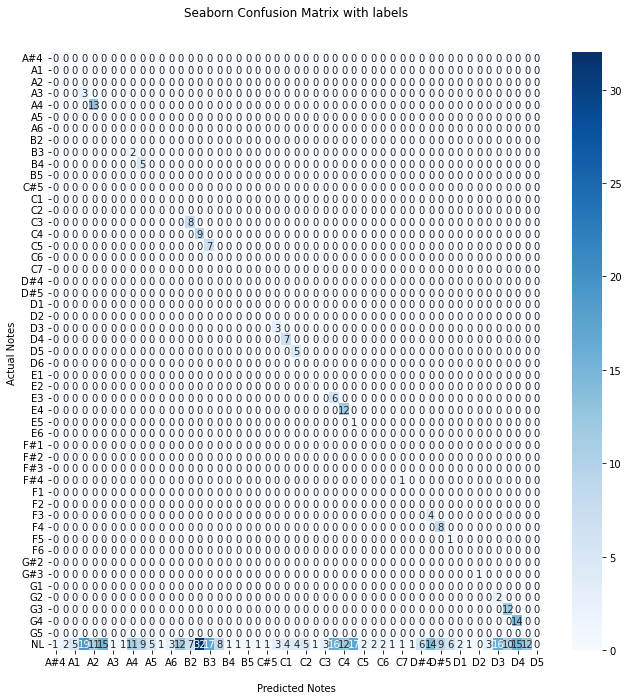

In [22]:
from glob import glob
import pandas as pd
import pretty_midi
from collections import Counter
from sklearn.metrics import accuracy_score
accuracy_list= []


def get_file_name(link):
    filename = link.split('/')[::-1][0]
    return filename.split('.')[::-1][1]

def get_file_extension(link):
    filename = link.split('/')[::-1][0]
    return filename.split('.')[::-1][0]

def load_notes(filename_midi):
  notes=[]
  midi_data = pretty_midi.PrettyMIDI(filename_midi)
  for instrument in midi_data.instruments:
    if not instrument.is_drum:
      for note in instrument.notes:
        notes.append(str(pretty_midi.note_number_to_name(note.pitch)))
  return notes

def calc_accuracy(df_dict):
  list_gtruth=[]
  list_transcribed=[]

  for i in df_dict.index:
    if (df_dict['Transcribed'][i].astype(int) > df_dict['GTruth'][i].astype(int)):
      for j in range(df_dict['Transcribed'][i].astype(int)):
        list_transcribed.append(i)
        if(j < df_dict['GTruth'][i].astype(int)):
          list_gtruth.append(i)
        else:
          list_gtruth.append('NL')
    else:
      for k in range(df_dict['GTruth'][i].astype(int)):
        list_gtruth.append(i)
        if(k < df_dict['Transcribed'][i].astype(int)):
          list_transcribed.append(i)
        else:
          list_transcribed.append('NL')

  return (accuracy_score(list_gtruth , list_transcribed)*100)

def confusion_matrix(df_dict):
  from sklearn.metrics import confusion_matrix
  from sklearn.utils.multiclass import unique_labels
  import seaborn as sns
  import matplotlib.pyplot as plt

  list_gtruth=[]
  list_transcribed=[]

  for i in df_dict.index:
    if (df_dict['Transcribed'][i].astype(int) > df_dict['GTruth'][i].astype(int)):
      for j in range(df_dict['Transcribed'][i].astype(int)):
        list_transcribed.append(i)
        if(j < df_dict['GTruth'][i].astype(int)):
          list_gtruth.append(i)
        else:
          list_gtruth.append('NL')
    else:
      for k in range(df_dict['GTruth'][i].astype(int)):
        list_gtruth.append(i)
        if(k < df_dict['Transcribed'][i].astype(int)):
          list_transcribed.append(i)
        else:
          list_transcribed.append('NL')

  labels_plot = unique_labels(list_gtruth, list_transcribed)
  cf_matrix = confusion_matrix(list_gtruth,list_transcribed,labels=labels_plot)

  fig, ax = plt.subplots(figsize=(11,11))         # Sample figsize in inches
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Notes')
  ax.set_ylabel('Actual Notes ');


  ax.xaxis.set_ticklabels(labels_plot)
  ax.yaxis.set_ticklabels(labels_plot)


  ## Display the visualization of the Confusion Matrix.
  plt.show()

def main():
  d = {0:'GTruth', 1:'Transcribed'}
  skip_transcription=0
  base_path = '/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset'
  os.chdir(base_path)
  transcribed_path = os.path.join(os.getcwd(), 'TranscribedFiles')

  if os.path.exists(transcribed_path):
    skip_transcription = 1
  else:
    os.mkdir('TranscribedFiles') # 1st run

  # start the process 
  wav_path = '/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/WavFiles/'
  #wav_path = '/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/testWavFiles/'

  #read all the wav filenames
  rec_files=[i for i in os.listdir(wav_path) if i.endswith(".wav")]

  for f in rec_files:
    gtruth_arr=[]
    transcribed_arr=[]
    grtruth_dict={}
    transcribed_dict={}
    df_dict = pd.DataFrame()

    print(f'Processing {f}...')

    if skip_transcription == 0:                    # Do transcription
      # Reading the wav file by converting to bytes
      audio = read_audio(os.path.join(wav_path,f),sample_rate=SAMPLE_RATE)
      
      # Transcribe the audio file
      est_ns = inference_model(audio)
      transcribed_file = os.path.join(transcribed_path, get_file_name(f) + '_transcribed.mid')
      note_seq.sequence_proto_to_midi_file(est_ns,transcribed_file )
    else:
      print(f'Skipping the transcription for file {f}...')
      transcribed_file = os.path.join(transcribed_path, get_file_name(f) + '_transcribed.mid')


    # find corresponding Gtruth MIDI file for comparison

    search_string = base_path + '/*/' + get_file_name(f) + '*mid'
    gtruth_file = glob(search_string)[0]

    gtruth_arr = load_notes(gtruth_file)
    transcribed_arr = load_notes(transcribed_file)

    grtruth_dict = Counter(gtruth_arr)
    transcribed_dict = Counter(transcribed_arr)

    df_dict = pd.DataFrame([grtruth_dict,transcribed_dict]).transpose()
    df_dict.rename(columns = d, inplace = True) 

    acc = calc_accuracy(df_dict)
    print(f'Accuracy for song {f} is {acc:.2f}%' )

    accuracy_list.append(acc)

  # Outside for loop

  print(f'Mean accuracy is {np.mean(accuracy_list):.2f}%')
  print()
  confusion_matrix(df_dict)


if __name__ == "__main__":
    main()

# Rerun on testwav directory

Processing MarchNo2Inter.wav...
Accuracy for song MarchNo2Inter.wav is 81.33%
Processing JoytotheWorldInter.wav...
Accuracy for song JoytotheWorldInter.wav is 65.38%
Processing JinglebellsInter.wav...
Accuracy for song JinglebellsInter.wav is 90.31%
Mean accuracy is 79.01%



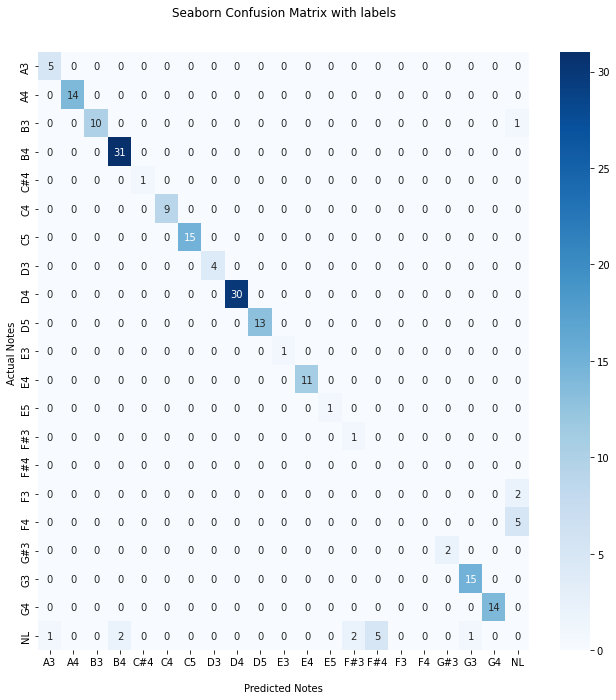

In [20]:
from glob import glob
import pandas as pd
import pretty_midi
from collections import Counter
from sklearn.metrics import accuracy_score
accuracy_list= []


def get_file_name(link):
    filename = link.split('/')[::-1][0]
    return filename.split('.')[::-1][1]

def get_file_extension(link):
    filename = link.split('/')[::-1][0]
    return filename.split('.')[::-1][0]

def load_notes(filename_midi):
  notes=[]
  midi_data = pretty_midi.PrettyMIDI(filename_midi)
  for instrument in midi_data.instruments:
    if not instrument.is_drum:
      for note in instrument.notes:
        notes.append(str(pretty_midi.note_number_to_name(note.pitch)))
  return notes

def calc_accuracy(df_dict):
  list_gtruth=[]
  list_transcribed=[]

  for i in df_dict.index:
    if (df_dict['Transcribed'][i].astype(int) > df_dict['GTruth'][i].astype(int)):
      for j in range(df_dict['Transcribed'][i].astype(int)):
        list_transcribed.append(i)
        if(j < df_dict['GTruth'][i].astype(int)):
          list_gtruth.append(i)
        else:
          list_gtruth.append('NL')
    else:
      for k in range(df_dict['GTruth'][i].astype(int)):
        list_gtruth.append(i)
        if(k < df_dict['Transcribed'][i].astype(int)):
          list_transcribed.append(i)
        else:
          list_transcribed.append('NL')

  return (accuracy_score(list_gtruth , list_transcribed)*100)

def confusion_matrix(df_dict):
  from sklearn.metrics import confusion_matrix
  from sklearn.utils.multiclass import unique_labels
  import seaborn as sns
  import matplotlib.pyplot as plt

  list_gtruth=[]
  list_transcribed=[]

  for i in df_dict.index:
    if (df_dict['Transcribed'][i].astype(int) > df_dict['GTruth'][i].astype(int)):
      for j in range(df_dict['Transcribed'][i].astype(int)):
        list_transcribed.append(i)
        if(j < df_dict['GTruth'][i].astype(int)):
          list_gtruth.append(i)
        else:
          list_gtruth.append('NL')
    else:
      for k in range(df_dict['GTruth'][i].astype(int)):
        list_gtruth.append(i)
        if(k < df_dict['Transcribed'][i].astype(int)):
          list_transcribed.append(i)
        else:
          list_transcribed.append('NL')

  labels_plot = unique_labels(list_gtruth, list_transcribed)
  cf_matrix = confusion_matrix(list_gtruth,list_transcribed,labels=labels_plot)

  fig, ax = plt.subplots(figsize=(11,11))         # Sample figsize in inches
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Notes')
  ax.set_ylabel('Actual Notes ');


  ax.xaxis.set_ticklabels(labels_plot)
  ax.yaxis.set_ticklabels(labels_plot)


  ## Display the visualization of the Confusion Matrix.
  plt.show()

def main():
  d = {0:'GTruth', 1:'Transcribed'}
  skip_transcription=0
  base_path = '/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset'
  os.chdir(base_path)
  transcribed_path = os.path.join(os.getcwd(), 'TranscribedFiles')

  if os.path.exists(transcribed_path):
    skip_transcription = 1
  else:
    os.mkdir('TranscribedFiles') # 1st run

  # start the process 
  #wav_path = '/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/WavFiles/'
  wav_path = '/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/testWavFiles/'

  #read all the wav filenames
  rec_files=[i for i in os.listdir(wav_path) if i.endswith(".wav")]

  for f in rec_files:
    gtruth_arr=[]
    transcribed_arr=[]
    grtruth_dict={}
    transcribed_dict={}
    df_dict = pd.DataFrame()

    print(f'Processing {f}...')

    if skip_transcription == 0:                    # Do transcription
      # Reading the wav file by converting to bytes
      audio = read_audio(os.path.join(wav_path,f),sample_rate=SAMPLE_RATE)
      
      # Transcribe the audio file
      est_ns = inference_model(audio)
      transcribed_file = os.path.join(transcribed_path, get_file_name(f) + '_transcribed.mid')
      note_seq.sequence_proto_to_midi_file(est_ns,transcribed_file )
    else:
      print(f'Skipping the transcription for file {f}...')
      transcribed_file = os.path.join(transcribed_path, get_file_name(f) + '_transcribed.mid')


    # find corresponding Gtruth MIDI file for comparison

    search_string = base_path + '/*/' + get_file_name(f) + '*mid'
    gtruth_file = glob(search_string)[0]

    gtruth_arr = load_notes(gtruth_file)
    transcribed_arr = load_notes(transcribed_file)

    grtruth_dict = Counter(gtruth_arr)
    transcribed_dict = Counter(transcribed_arr)

    df_dict = pd.DataFrame([grtruth_dict,transcribed_dict]).transpose()
    df_dict.rename(columns = d, inplace = True) 

    acc = calc_accuracy(df_dict)
    print(f'Accuracy for song {f} is {acc:.2f}%' )

    accuracy_list.append(acc)

  # Outside for loop

  print(f'Mean accuracy is {np.mean(accuracy_list):.2f}%')
  print()
  confusion_matrix(df_dict)


if __name__ == "__main__":
    main()

# Rough work

In [21]:
base_path = '/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/GtruthMIDIFiles_SharpEye'
base_path_w = '/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/WavFiles'
for root, folders, files in os.walk(base_path_w):
  print(len(files))
  for f in files:
    print(f)
    search_string = base_path +'/' + get_file_name(f) + '*mid'
    gtruth_file = glob(search_string)[0]



for root, folders, files in os.walk(base_path):
  print(len(files))

47
OHolyNightInter.wav
OHolyNightAdv.wav
MarchNo2Inter.wav
MarchNo2Adv.wav
JoytotheWorldInter.wav
JoytotheWorldAdv.wav
AveMariaInter.wav
AveMariaAdv.wav
AveMariaPro.wav
LittleDrummerBoyInter.wav
LittleDrummerBoyAdv.wav
AngelsWehaveHeardInter.wav
AngelsWehaveHeardAdv.wav
IwillbeHomeForchristmasAdv.wav
WaltzoftheflowersAdv.wav
TheSoundsofSnowfallInter.wav
TheSoundsofSnowfallAdv.wav
JinglebellsInter.wav
TheSoundsofSnowfallPro.wav
FrostyTheSnowmanInter.wav
FrostyTheSnowmanAdv.wav
FrostyTheSnowmanPro.wav
YouaremeanoneAdv.wav
WinterWonderlandInter.wav
WeThreeKingsInter.wav
WeThreeKingsAdv.wav
SantababyInter.wav
RudolphtheRedInter.wav
FelizNavidadAdv.wav
LastChristmasPro.wav
LastChristmasInter.wav
LastChristmasAdv.wav
HaveyourselfAMerry.wav
WeWishyouInter.wav
WeWishyouAdv.wav
JesujoyInter.wav
JesuJoyPro.wav
AllIwantforChristmasInter.wav
OChristmasInter.wav
DanceoftheAdv.wav
OChristmasAdv.wav
DanceofthePro.wav
DanceoftheInter.wav
FelizNavidadInter.wav
JinglebellsAdv.wav
SilentNightInter.wav
Si